In [30]:
import sys
sys.path.append(r"C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages")
import os
from pathlib import Path
import json
import random
import numpy as np
import spacy


from tqdm import tqdm
import pickle
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from spacy.language import Language
from luima_sbd import sbd_utils as luima
import seaborn as sns
import plotly.express as px
import math
import fasttext

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree

%matplotlib inline

# Step 5.1: TF-IDF Featurization

In [64]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [55]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

In [31]:
CURATED_ANN_PATH = "../Data/ldsi_w2021-20220221T223611Z-001/ldsi_w2021/ldsi_w21_curated_annotations_v2.json"
with open(CURATED_ANN_PATH, 'r') as j:
     data = json.loads(j.read())
        
data.keys()

dict_keys(['documents', 'annotations', 'types'])

In [32]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

In [33]:
documents_by_id['61aea55c97ad59b4cfc4128c'].keys()

dict_keys(['_id', 'name', 'plainText', 'outcome'])

In [34]:
annotations[0]

{'_id': '61bb066d97ad59b4cfc4699a',
 'start': 15922,
 'end': 16078,
 'document': '61aea57397ad59b4cfc41399',
 'type': '61aeaf8097ad59b4cfc416d7'}

In [35]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations, doc_ids):
    span_data = []
    for doc_id in doc_ids:
        for a in annotations:
            if a['document'] == doc_id:
                start = a['start']
                end = a['end']
                document_txt = documents_by_id[a['document']]['plainText']
                atype = a['type']
                sd = {'txt': document_txt[start:end],
                      'document': a['document'],
                      'type': types_by_id[atype]['name'],
                      'start': a['start'],
                      'start_normalized': a['start'] / len(document_txt),
                      'end': a['end']}
                span_data.append(sd)
    return span_data

In [36]:
train_ids, dev_ids, test_ids = np.load('../Data/train.npy'), np.load('../Data/dev.npy'), np.load('../Data/test.npy')
train_ids.shape, dev_ids.shape, test_ids.shape

((113,), (14,), (14,))

In [37]:
train_spans = make_span_data(documents_by_id, types_by_id, annotations, train_ids)
dev_spans = make_span_data(documents_by_id, types_by_id, annotations, dev_ids)
test_spans = make_span_data(documents_by_id, types_by_id, annotations, test_ids)

train_spans_txt = [s['txt'] for s in train_spans]
dev_spans_txt = [s['txt'] for s in dev_spans]
test_spans_txt = [s['txt'] for s in test_spans]
len(train_spans), len(dev_spans), len(test_spans), len(train_spans_txt), len(dev_spans_txt), len(test_spans_txt) 

(12450, 1376, 1523, 12450, 1376, 1523)

In [96]:
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])

def custom_spacy_tokenize(txt):
    nlp.disable_pipes('parser')
    doc = nlp.pipe(txt, n_process=4)
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    
#     print(txt)
    for i, token in enumerate(tokens):
#         print(token)
#         print(f"token: {token} | {token.pos_}")
        if token.pos_ == 'PUNCT' and not re.search("^[0-9]{2}/[0-9]{2}/([0-9]{2}|[0-9]{4})$", token.text):
            pass
        
        elif token.pos_ == 'NUM':
            refined_token = re.sub(r'\W', '', token.text)
            clean_tokens.append(f'<NUM{len(refined_token)}>')
            
        elif token.text == "\'s" and token.pos_ == 'PART':
#             continue
#             print(clean_tokens)
#             print(token, tokens[i-1])
            pos_token = tokens[i-1].text + token.text
            clean_tokens.pop(len(clean_tokens)-1)
            clean_tokens.append(pos_token.lower())
            
            
#             clean_tokens.remove(tokens[i-1].text.lower())
            
#             refined_token = re.sub(r'\W', '', pos_token.lower())
            
#             if refined_token.isnumeric():
#                 refined_token = f'<NUM{len(refined_token)}>'
                
#             if not refined_token == "":
#                 print(f"refined token = {refined_token}")
#                 clean_tokens.append(pos_token.lower())
#                 clean_tokens.remove(tokens[i-1].text.lower())
                   
        elif "-" in token.text:
            splitted_tokens = token.text.split("-")

            for sp_token in splitted_tokens:
                refined_token = re.sub(r'\W', '', sp_token.lower())
                if refined_token != "":
                    if refined_token.isnumeric():
                        refined_token = f'<NUM{len(refined_token)}>'
                    clean_tokens.append(refined_token)
        elif token.text in ("Vet. App.", "Fed. Cir."):
            clean_tokens.append(token.lemma_.lower())
#         elif "." in token.text and token.text in ("Vet. App.", "Fed. Cir."):
#             print(f"Special condition fulfilled: {token.text}")
#             splitted_tokens = token.text.split(".")

#             for sp_token in splitted_tokens:
#                 refined_token = re.sub(r'\W', '', sp_token.lower())
#                 if refined_token != "":
#                     if refined_token.isnumeric():
#                         refined_token = f'<NUM{len(refined_token)}>'
#                     clean_tokens.append(refined_token)
        else:
            refined_token = re.sub(r'\W', '', token.lemma_.lower())
#             print(f"refined token: {refined_token}")
            if re.search('\d+', refined_token) and re.search('[a-zA-Z]+', refined_token):
#                 print("Matched mixed")
                continue
            elif refined_token != "" and refined_token.isnumeric():
#                 print("Matched digit only")
                refined_token = f'<NUM{len(refined_token)}>'
                clean_tokens.append(refined_token)

            elif refined_token != "":
#                 print(f"Nothing matched, inserting {refined_token}")
                clean_tokens.append(refined_token)
                    
    return clean_tokens

def custom_spans_add_spacy_tokens(spans):
    for s in tqdm(spans):
        s['tokens_spacy'] = custom_spacy_tokenize(s['txt'])
        s['token_count'] = len(s['tokens_spacy'])

In [97]:
custom_spans_add_spacy_tokens(train_spans)
custom_spans_add_spacy_tokens(test_spans)

100%|█████████████████████████████████████████████████████████████████████████| 1523/1523 [00:06<00:00, 230.71it/s]


In [98]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))

spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)

tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names_out()

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [99]:
len(tfidf_features_spacy)

3050

In [100]:
# numpy feature vector extension
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
print(train_tfidf_spacy.shape)

train_starts_normalized = np.array([s['start_normalized'] for s in train_spans])
print(train_starts_normalized.shape)
print(np.expand_dims(train_starts_normalized, axis=1).shape)

ext = np.concatenate((train_tfidf_spacy, 
                      np.expand_dims(train_starts_normalized, axis=1)), axis=1)
print(ext.shape)

(12450, 3050)
(12450,)
(12450, 1)
(12450, 3051)


In [101]:
dfs = top_features_by_class(train_tfidf_spacy, train_spans_labels, tfidf_features_spacy)
dfs['Citation']

,feature,tfidf
0,<NUM2>,0.286290
1,<NUM4>,0.265477
2,cfr,0.172592
3,<NUM3>,0.168517
4,v,0.113447
5,vet,0.103533
6,app,0.103502
7,usca,0.101209
8,see,0.097789
9,<NUM1>,0.057235


In [102]:
def make_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1)), axis=1)
    return X, y

In [88]:
train_spans[0]

{'txt': 'Citation Nr: 0922385\t\r\nDecision Date: 06/15/09    Archive Date: 06/23/09\r\n\r\nDOCKET NO.  06-34 165A\t)\tDATE\r\n\t)\r\n\t)',
 'document': '61aea55c97ad59b4cfc412af',
 'type': 'CaseHeader',
 'start': 0,
 'start_normalized': 0.0,
 'end': 113}

In [103]:
train_X, train_y = make_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
test_X, test_y = make_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [105]:
print(f'{train_X.shape} {train_y.shape}')
print(f'{test_X.shape} {test_y.shape}')

(12450, 3051) (12450,)
(1523, 3051) (1523,)


In [106]:
#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(train_X, train_y)

In [107]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('TEST:\n'+classification_report(test_spans_labels, clf.predict(test_X)))

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.99      1.00       115
                         CaseIssue       1.00      0.99      1.00       114
                          Citation       1.00      0.98      0.99      1983
                   ConclusionOfLaw       0.87      0.79      0.83       274
                          Evidence       0.78      0.90      0.83      3859
EvidenceBasedOrIntermediateFinding       0.77      0.53      0.63      1178
            EvidenceBasedReasoning       0.47      0.40      0.43       874
                            Header       0.92      0.99      0.95      1159
                         LegalRule       0.75      0.77      0.76      1549
              LegislationAndPolicy       0.97      0.42      0.59       135
              PolicyBasedReasoning       0.75      0.20      0.32        15
    

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


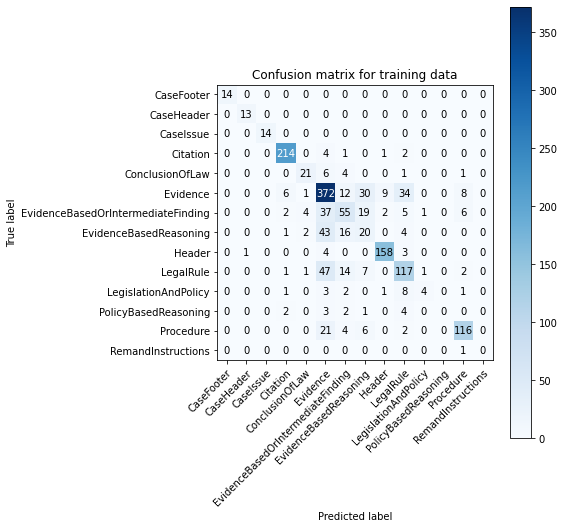

In [108]:
plot_confusion_matrix(test_spans_labels, clf.predict(test_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

In [109]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [111]:
prediction_errors(clf,
                  random.sample(train_spans, 100),
                  spacy_tfidf_vectorizer,
                  select_pred_label='Evidence')

sentence # 2 / case 0805441.txt / @1197
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
1.  The veteran served in combat in the Republic of Vietnam, 
and is in receipt of the Purple Heart Medal and Combat 
Infantry Badge.

sentence # 16 / case 1622612.txt / @3062
pred: Evidence / true: LegalRule
Under certain circumstances, additional development, including obtaining additional records and providing the veteran with a VA medical examination, may still be required prior to the adjudication of the claim.

sentence # 20 / case 1203188.txt / @15885
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Although post service treatment records show an assessment of PTSD and possible PTSD, there is no evidence diagnosing PTSD in accordance with 38 C.F.R. � 4.125.

sentence # 38 / case 0842824.txt / @9901
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Based upon the 
reasons for the prior denial, the evidence indicating a 
relationship between the veteran's hearing loss

In [112]:
train_tfidf_spacy = vectorizer_spacy.transform(train_spans_txt).toarray()
test_tfidf_spacy = vectorizer_spacy.transform(test_spans_txt).toarray()
dev_tfidf_spacy = vectorizer_spacy.transform(dev_spans_txt).toarray()

train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])

In [113]:
print("train data: ", train_tfidf_spacy.shape, train_spans_labels.shape)
print("dev data: ", dev_tfidf_spacy.shape, dev_spans_labels.shape)
print("test data: ", test_tfidf_spacy.shape, test_spans_labels.shape)


train data:  (12450, 3050) (12450,)
dev data:  (1376, 3050) (1376,)
test data:  (1523, 3050) (1523,)


In [115]:
custom_spans_add_spacy_tokens(train_spans)
custom_spans_add_spacy_tokens(test_spans)
custom_spans_add_spacy_tokens(dev_spans)

100%|█████████████████████████████████████████████████████████████████████████| 1376/1376 [00:06<00:00, 226.92it/s]


In [116]:
%time train_X, train_y = make_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
dev_X, dev_y = make_feature_vectors_and_labels(dev_spans, spacy_tfidf_vectorizer)
test_X, test_y = make_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

CPU times: total: 53.2 s
Wall time: 53.2 s


In [117]:
print(f'{train_X.shape} {train_y.shape}')
print(f'{dev_X.shape} {dev_y.shape}')
print(f'{test_X.shape} {test_y.shape}')

(12450, 3051) (12450,)
(1376, 3051) (1376,)
(1523, 3051) (1523,)


## Part 5.2: Word embedding vectors

In [127]:
model = fasttext.load_model("../Data/ft_word_embedding_model.bin")
len(model.get_words(on_unicode_error='ignore'))

12217

In [128]:
def add_word_vec(spans):
    for s in spans:
        final_vector= []
        sum_vec= np.zeros(100)
        if(len(s["tokens_spacy"])!=0):
            for word in s['tokens_spacy']:
                w_vec = model.get_word_vector(word)
                sum_vec=np.add(w_vec,sum_vec)
            final_vector=sum_vec/s['tokens_number']
            s['word_vec']=final_vector
        else:
            s['word_vec']=np.zeros(100)

# add_word_vec(train_spans)
add_word_vec(dev_spans)
# add_word_vec(test_spans)

KeyError: 'tokens_number'

## Trying out different models

### Linear Support Vector Machine Classifier (Linear Model)

CPU times: total: 312 ms
Wall time: 307 ms
Linear Support Vector Machine
TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.96      0.99      0.97       114
                          Citation       1.00      1.00      1.00      1983
                   ConclusionOfLaw       0.94      0.93      0.93       274
                          Evidence       0.91      0.96      0.94      3859
EvidenceBasedOrIntermediateFinding       0.84      0.80      0.82      1178
            EvidenceBasedReasoning       0.84      0.62      0.72       874
                            Header       0.99      0.99      0.99      1159
                         LegalRule       0.91      0.97      0.94      1549
              LegislationAndPolicy       0.81      0.52      0.63       135
       

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

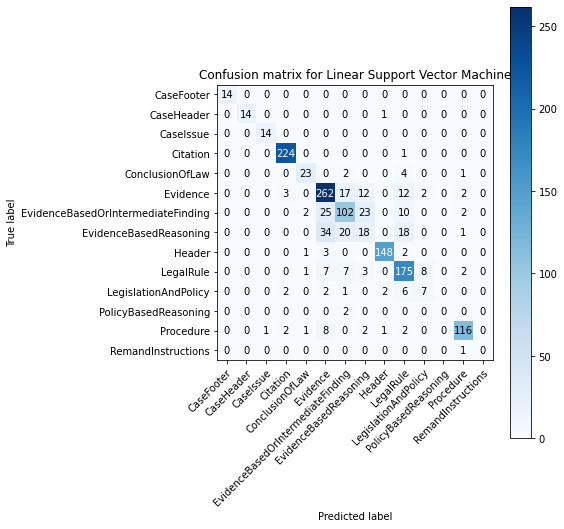

In [120]:
from sklearn.svm import LinearSVC

param_distributions = {'n_estimators': np.random.randint(1, 5),
                       'max_depth': np.random.randint(5, 10)}
model_ident="Linear Support Vector Machine"
clf = LinearSVC(random_state=0, tol=1e-4)
%time clf = clf.fit(train_X, train_y)
print(f'{model_ident}\nTRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print(f'{model_ident}\nDEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()

### Logistic Regression

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Pre

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.93      0.97      0.95       114
                          Citation       0.98      0.98      0.98      1983
                   ConclusionOfLaw       0.93      0.82      0.87       274
                          Evidence       0.84      0.96      0.89      3859
EvidenceBasedOrIntermediateFinding       0.75      0.65      0.70      1178
            EvidenceBasedReasoning       0.71      0.42      0.53       874
                            Header       0.99      0.98      0.98      1159
                         LegalRule       0.87      0.92      0.89      1549
              LegislationAndPolicy       0.75      0.29      0.42       135
              PolicyBasedReasoning       0.00      0.00      0.00        15
    

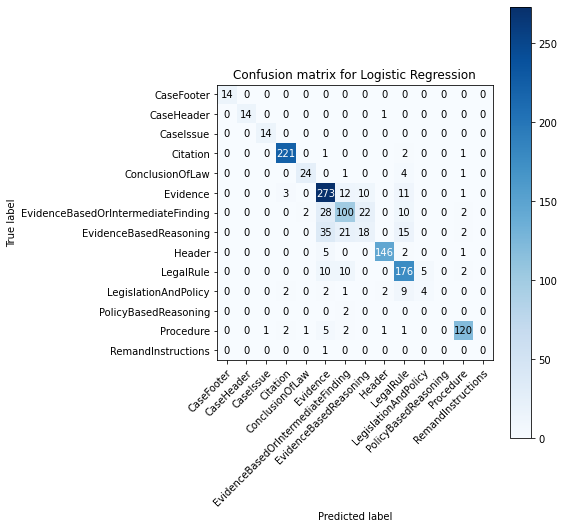

In [121]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf = clf.fit(train_X, train_y)
model_ident="Logistic Regression"
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()

### Radial kernel SVM

CPU times: total: 2min 5s
Wall time: 2min 6s


C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.96      0.99      0.97       114
                          Citation       0.99      1.00      1.00      1983
                   ConclusionOfLaw       0.96      0.92      0.94       274
                          Evidence       0.91      0.98      0.95      3859
EvidenceBasedOrIntermediateFinding       0.90      0.85      0.87      1178
            EvidenceBasedReasoning       0.90      0.69      0.78       874
                            Header       0.99      1.00      0.99      1159
                         LegalRule       0.93      0.97      0.95      1549
              LegislationAndPolicy       0.84      0.47      0.60       135
              PolicyBasedReasoning       0.00      0.00      0.00        15
    

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

DEV:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       0.93      1.00      0.97        14
                          Citation       0.97      0.98      0.97       225
                   ConclusionOfLaw       0.90      0.87      0.88        30
                          Evidence       0.74      0.92      0.82       310
EvidenceBasedOrIntermediateFinding       0.76      0.61      0.68       164
            EvidenceBasedReasoning       0.36      0.20      0.26        91
                            Header       0.98      0.95      0.97       154
                         LegalRule       0.80      0.86      0.83       203
              LegislationAndPolicy       0.44      0.35      0.39        20
              PolicyBasedReasoning       0.00      0.00      0.00         2
      

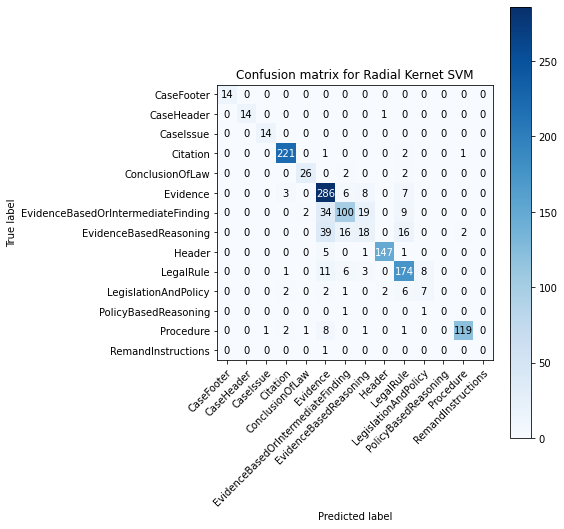

In [122]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', random_state=0)
%time clf = clf.fit(train_X, train_y)
model_ident="Radial Kernet SVM"
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()

### Polynomial kernel SVM

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.98      0.99      0.99       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       0.90      0.99      0.95       114
                          Citation       0.98      0.99      0.98      1983
                   ConclusionOfLaw       0.65      0.76      0.70       274
                          Evidence       0.75      0.90      0.82      3859
EvidenceBasedOrIntermediateFinding       0.44      0.41      0.42      1178
            EvidenceBasedReasoning       0.55      0.20      0.29       874
                            Header       0.98      0.98      0.98      1159
                         LegalRule       0.86      0.81      0.83      1549
              LegislationAndPolicy       0.80      0.30      0.43       135
              PolicyBasedReasoning       0.00      0.00      0.00        15
    

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

DEV:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       0.93      1.00      0.97        14
                          Citation       0.94      0.99      0.96       225
                   ConclusionOfLaw       0.69      0.80      0.74        30
                          Evidence       0.65      0.83      0.73       310
EvidenceBasedOrIntermediateFinding       0.43      0.42      0.42       164
            EvidenceBasedReasoning       0.34      0.13      0.19        91
                            Header       0.98      0.97      0.97       154
                         LegalRule       0.79      0.74      0.77       203
              LegislationAndPolicy       0.50      0.20      0.29        20
              PolicyBasedReasoning       0.00      0.00      0.00         2
      

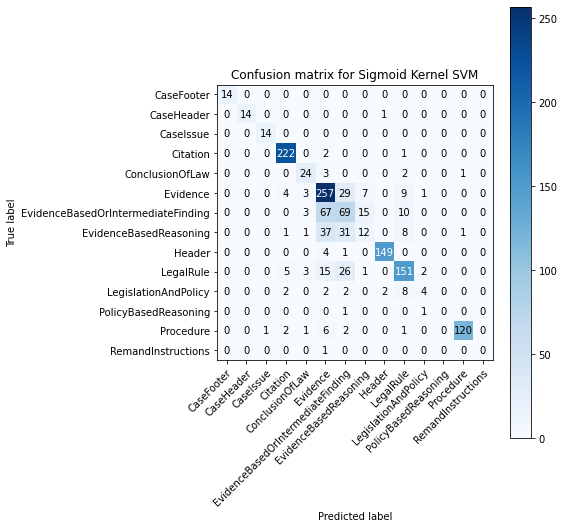

In [123]:
clf = SVC(kernel='sigmoid', random_state=0)
clf = clf.fit(train_X, train_y)
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
model_ident="Sigmoid Kernel SVM"
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()

### Decision Trees

CPU times: total: 2.86 s
Wall time: 2.86 s


C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.99      1.00       115
                         CaseIssue       1.00      0.99      1.00       114
                          Citation       1.00      0.99      0.99      1983
                   ConclusionOfLaw       0.95      0.78      0.86       274
                          Evidence       0.82      0.90      0.86      3859
EvidenceBasedOrIntermediateFinding       0.88      0.56      0.69      1178
            EvidenceBasedReasoning       0.51      0.49      0.50       874
                            Header       0.93      0.99      0.96      1159
                         LegalRule       0.75      0.86      0.80      1549
              LegislationAndPolicy       0.98      0.48      0.65       135
              PolicyBasedReasoning       1.00      0.20      0.33        15
    

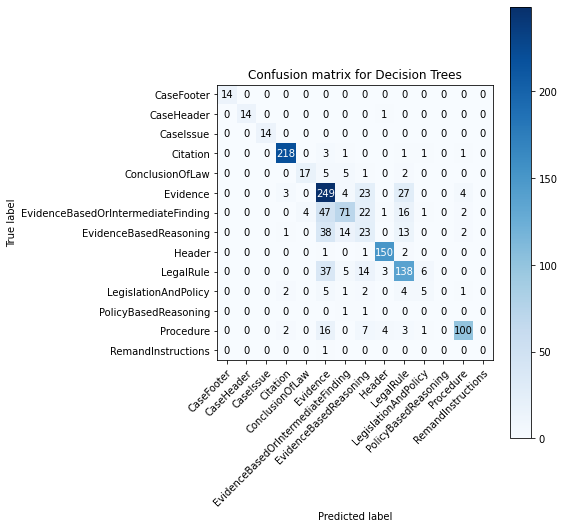

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 13,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

In [124]:
clf = tree.DecisionTreeClassifier(max_depth=13, random_state=0)
%time clf = clf.fit(train_X, train_y)
model_ident = "Decision Trees"
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()
clf.get_params()

### Random Forests

CPU times: total: 953 ms
Wall time: 956 ms


C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       115
                         CaseIssue       1.00      0.04      0.07       114
                          Citation       0.98      0.95      0.96      1983
                   ConclusionOfLaw       0.00      0.00      0.00       274
                          Evidence       0.48      0.99      0.65      3859
EvidenceBasedOrIntermediateFinding       0.84      0.20      0.32      1178
            EvidenceBasedReasoning       1.00      0.00      0.01       874
                            Header       1.00      0.53      0.69      1159
                         LegalRule       0.91      0.54      0.68      1549
              LegislationAndPolicy       1.00      0.06      0.11       135
              PolicyBasedReasoning       0.00      0.00      0.00        15
    

C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


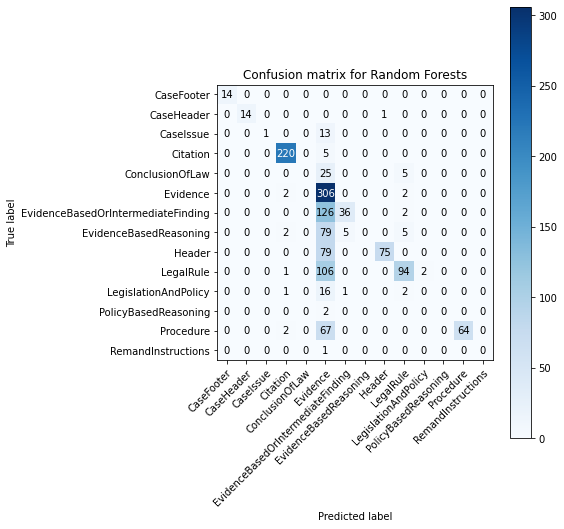

In [125]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
file_name="random_forest"
clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=20)
%time clf = clf.fit(train_X, train_y)
model_ident = "Random Forests"
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title=f'Confusion matrix for {model_ident}')
plt.show()


## Best Model